In [57]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from pennylane import draw_mpl

In [58]:
# Problem setup
mu = np.array([0.10, 0.20, 0.15, 0.12])  # Expected returns
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
])

n_assets = len(mu)
q = 0.5  # Risk aversion parameter

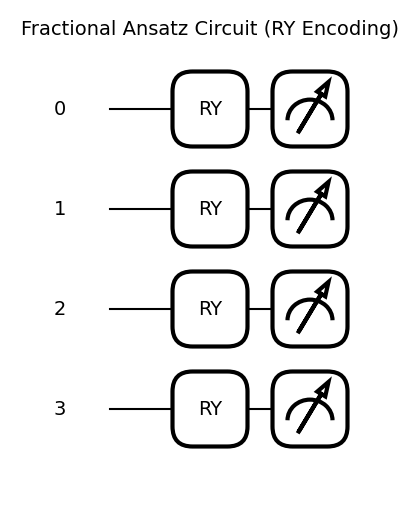

In [59]:
dev = qml.device("default.qubit", wires=n_assets)

# Convert RY angles to weights (probability of measuring |1⟩)
def weights_from_thetas(thetas):
    return np.sin(thetas / 2) ** 2

@qml.qnode(dev)
def circuit(thetas):
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]

# Sample theta values for visualization
sample_thetas = np.linspace(0, np.pi, n_assets)

# Draw circuit using draw_mpl
fig, ax = draw_mpl(circuit)(sample_thetas)
fig.suptitle("Fractional Ansatz Circuit (RY Encoding)", fontsize=14)
plt.show()


In [60]:
def cost_fn(thetas):
    weights = weights_from_thetas(thetas)
    expected_return = np.dot(mu, weights)
    risk = np.dot(weights, np.dot(Sigma, weights))
    penalty = 20 * (np.sum(weights) - 1.0) ** 2  # Encourage total weight = 1
    return -expected_return + q * risk + penalty

thetas = np.random.uniform(0, np.pi, n_assets, requires_grad=True)
opt = AdamOptimizer(0.1)
steps = 100
costs = []

for i in range(steps):
    thetas = opt.step(cost_fn, thetas)
    current_cost = cost_fn(thetas)
    costs.append(current_cost)
    if i % 5 == 4:
        print(f"Step {i} | Cost: {current_cost:.4f}")

Step 4 | Cost: 0.0629
Step 9 | Cost: 1.6094
Step 14 | Cost: 0.0915
Step 19 | Cost: 0.1689
Step 24 | Cost: 0.1274
Step 29 | Cost: -0.1182
Step 34 | Cost: -0.0031
Step 39 | Cost: -0.1368
Step 44 | Cost: -0.0929
Step 49 | Cost: -0.1350
Step 54 | Cost: -0.1242
Step 59 | Cost: -0.1371
Step 64 | Cost: -0.1341
Step 69 | Cost: -0.1392
Step 74 | Cost: -0.1376
Step 79 | Cost: -0.1401
Step 84 | Cost: -0.1394
Step 89 | Cost: -0.1405
Step 94 | Cost: -0.1405
Step 99 | Cost: -0.1408


In [61]:
weights = weights_from_thetas(thetas)
weights = weights / np.sum(weights)  # Normalize

print("Optimized Portfolio Allocation:")
for i, w in enumerate(weights):
    print(f"Asset {i+1}: {float(w)*100:.2f}%")

Optimized Portfolio Allocation:
Asset 1: 21.59%
Asset 2: 15.57%
Asset 3: 56.46%
Asset 4: 6.37%


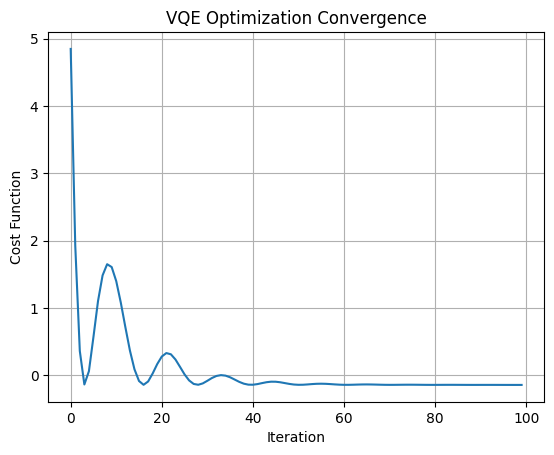

In [62]:
plt.plot(range(steps), costs)
plt.title("VQE Optimization Convergence")
plt.xlabel("Iteration")
plt.ylabel("Cost Function")
plt.grid(True)
plt.show()

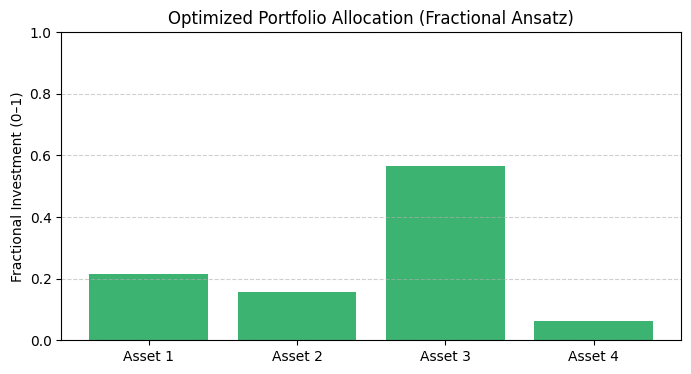

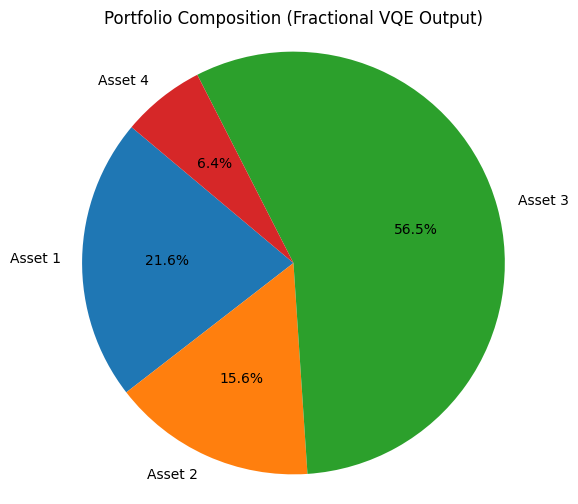

In [63]:
asset_labels = [f"Asset {i+1}" for i in range(n_assets)]

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(asset_labels, weights, color='mediumseagreen')
plt.title("Optimized Portfolio Allocation (Fractional Ansatz)")
plt.ylabel("Fractional Investment (0–1)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(weights, labels=asset_labels, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Composition (Fractional VQE Output)")
plt.axis('equal')
plt.show()